In [1]:
from global_variables_final_for_git import Global_Vars
from prep_for_model_for_git import Model_preparation
import pandas as pd
import os

if __name__=="__main__":
    class Args(object):
        def __init__(self):
            self.gene = "NANOG"
            self.distance = 200
            self.use_tad_info = True
            self.pcc_lowerlimit_to_filter_dhss = 0.25
            self.take_log2_tpm = True
            self.filter_tfs_by = "zscore" # or "pcc"
            self.lowerlimit_to_filter_tfs = 4.75
            self.take_this_many_top_fts = 15  # all dhss/tfs will already be filtered by pcc(or zscore)
            self.init_wts_type = "corr"
            self.outputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_git/Output/testing"
            self.use_random_DHSs = False
            self.use_random_TFs = False
            self.max_iter = 300

    args = Args()
    gv = Global_Vars(args, args.outputDir)  # note this takes in new_output_dir as well in .py scripts
    mp = Model_preparation(gv)

2018-01-12 22:06:56,485: global_variables_final_for_git: INFO    : Setting up the DNase-seq dataframe and gene expression vector..
global_variables_final_for_git.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_roi_dhss["pcc"] = pccs
2018-01-12 22:07:06,278: global_variables_final_for_git: INFO    : Done. Setting up the training and testing split..
2018-01-12 22:07:06,279: prep_for_model_for_git: INFO    : Preparing the dataframe for train/test splits..


## Hyperparameter search

Source: https://github.com/itdxer/neupy/blob/master/notebooks/Hyperparameter%20optimization%20for%20Neural%20Networks.ipynb
and http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#id14

```python
Hyperparams to train:
1. lambda
2. number of hidden layers
3. number of hidden units
3. starter learning rate
5. use_sigmoid_h1
6. use_sigmoid_h2```

In [8]:
from tensorflow_model_for_git import Tensorflow_model

In [6]:
import hyperopt
from functools import partial
from hyperopt import fmin, tpe, hp


'''Define some basic HPO functions and variables'''
def uniform_int(name, lower, upper):
    # `quniform` returns: round(uniform(low, high) / q) * q
    return hp.quniform(name, lower, upper, q=1)

def loguniform_int(name, lower, upper):
    # Do not forget to make a logarithm for the lower and upper bounds.
    return hp.qloguniform(name, np.log(lower), np.log(upper), q=1)

tpe = partial(
    hyperopt.tpe.suggest,
    n_EI_candidates=30,     # Sample 1000 candidate and select candidate that has highest Expected Improvement (EI)
    gamma=0.2,     # Use 20% of best observations to estimate next set of parameters
    n_startup_jobs=6,     # First 20 trials are going to be random
)

def get_parameter_space_forHPO(trainX):
    h1_lower = int(0.33 * trainX.shape[1])
    h1_upper = int(0.66 * trainX.shape[1])
    parameter_space = {
        'layers': hp.choice('layers', [{
            'n_layers': 1,
            'n_units_layer': [
                uniform_int('n_units_layer_11', h1_lower, h1_upper),
            ],
        }, {
            'n_layers': 2,
            'n_units_layer': [
                uniform_int('n_units_layer_21', h1_lower, h1_upper),
                uniform_int('n_units_layer_22', int(0.66 * h1_lower), int(0.66 * h1_upper)),
            ],
        }]),
        'lamda': 5*10**(-1 * uniform_int("lamda", 1, 7))
    }
    return parameter_space

lamda:0.0005, layer_sizes:[10]
lamda:5e-05, layer_sizes:[10]
lamda:5e-05, layer_sizes:[18, 9]
lamda:0.05, layer_sizes:[11, 10]
lamda:0.005, layer_sizes:[15]
lamda:5e-06, layer_sizes:[12]
lamda:0.5, layer_sizes:[19]
lamda:0.05, layer_sizes:[17]
lamda:0.5, layer_sizes:[19]
lamda:5e-07, layer_sizes:[19, 6]


2018-01-12 22:10:30,796: __main__    : INFO    : Test Group 1:Digestive, Median Test Percentage Error: 0.12, Best Params: {'layers': 0, 'lamda': 2.0, 'n_units_layer_11': 17.0}
2018-01-12 22:10:30,796: __main__    : INFO    : Test Group 1:Digestive, Median Test Percentage Error: 0.12, Best Params: {'layers': 0, 'lamda': 2.0, 'n_units_layer_11': 17.0}


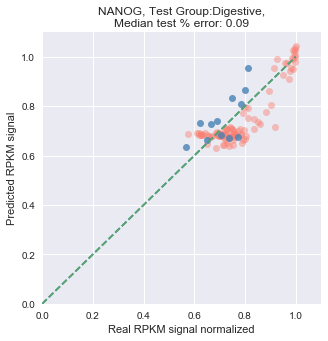

In [7]:
'''Run HPO on differen train/test splits'''
# for test_idx in range(0, 19):
test_idx = 3

tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx)
trials = hyperopt.Trials()

best_params = hyperopt.fmin(
    tm.train_tensorflow_nn,
    trials=trials,
    space=get_parameter_space_forHPO(tm.trainX),
    algo=tpe,     # Set up TPE for hyperparameter optimization
    max_evals=10,     # Maximum number of iterations. Basically it trains at most 200 networks before choose the best one.
)

med_pc_test_error = tm.plot_scatter_performance(trials, gv, index=None)
tm.logger.info("Test Group {}:{}, Median Test Percentage Error: {}, Best Params: {}".format(1, tm.test_eid_group, 0.12, best_params))

# if (test_idx == 1): 
#     break

#del tm, trials

Text(0.5,1,u'NANOG, Test Group:Digestive,\nMedian test % error: 0.09')

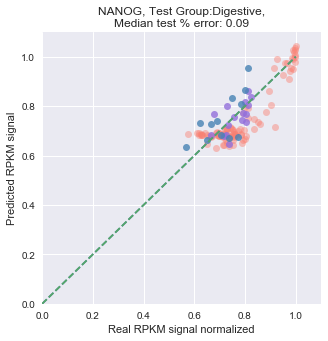

In [11]:
index = np.argmin(trials.losses()) 
plt.figure(figsize=(5, 5))
sns.regplot(tm.trainY.flatten(), trials.results[index]["yhat_train"].flatten(), robust=False, fit_reg=False, scatter_kws={'alpha': 0.45}, color="salmon")
sns.regplot(tm.valY.flatten(), trials.results[index]["yhat_val"].flatten(), robust=False, fit_reg=False, color="honeydew")
sns.regplot(tm.testY.flatten(), trials.results[index]["yhat_test"].flatten(), robust=False, fit_reg=False, color="steelblue")
plt.xlim((0, 1.1))
plt.ylim((0, 1.1))
plt.plot([[0, 0], [1, 1]], "--")
plt.xlabel("Real RPKM signal normalized")
plt.ylabel("Predicted RPKM signal")
med_pc_test_error = np.median(tm.get_percentage_error(trials.results[index]["yhat_test"].flatten()))
plt.title("{}, Test Group:{},\nMedian test % error: {}".format(gv.gene_ofInterest, tm.test_eid_group, round(med_pc_test_error, 2)))

In [ ]:
# - EOF - 